## Chest X-Ray Multi-Label Classification via Deep Convolutional Neural Networks

In [1]:
# Edit all the Mardown cells below with the appropriate information 
# Run all cells, containing your code 
# Save this Jupyter with the outputs of your executed cells
#
# PS: Save again the notebook with this outcome.
# PSPS: Don't forget to include the dataset in your submission

**Team:**
* Andrew Dant
* Alicia Hernandez

**Course:** DAAN 897– Deep Learning (Spring II, 2020)

### Problem Statement
*  Our goal is to further existing research using deep learning for medical diagnosis and apply it to a dataset comprised of chest X-rays and associated patient data using previously established deep convolutional neural networks. We used transfer learning techniques to train a variety of machine learning models to classify 15 different diseases present in the x ray images.

### Data Collection
* Source(url): https://www.kaggle.com/datasets/nih-chest-xrays/data
* Short Description : 112,120 X-ray images with disease labels from 30,805 unique patients

#### The dataset is very large (44 gb) so we could not include it with our submission. Please visit the source url and click the download button. Once the download has finished you must extract the zip file and point the 'path' variable below to the correct directory.

### Required packages

* Add instructions to install the required packages


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import os
import codecs, json
from sklearn.metrics import roc_curve, roc_auc_score
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from keras.applications.resnet import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Concatenate, Dropout
from keras.optimizers import Adam

In [3]:
# !IMPORTANT!
# this path must point to the directory where you have extracted the 'archive' folder of the dataset
path = r"C:\Users\andrew.dant\Downloads\archive"
os.chdir(path)
patients = pd.read_csv("Data_Entry_2017.csv")

### Data Preprocessing

* Enumerate and present the main steps you preformed in the data preprocessing
* Add your code and interpret the outcome of main steps/functions


In [4]:
print(patients.head())
print(patients.columns)
print(patients.describe())
print(patients.shape)  #(112120, 12)
print(patients.dtypes)     #object, int64, float64

        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN 

In [5]:
print(patients['Patient Gender'].unique())
# encode patient gender as zero or one
patients['Patient Gender'] = patients['Patient Gender'].map({'M': 0, 'F': 1})

print(patients['View Position'].unique())
patients['View Position'] = patients['View Position'].map({'PA': 0, 'AP': 1})

['M' 'F']
['PA' 'AP']


In [6]:
# empty/fake column caused by a trailing comma in the CSV file
columns_to_drop = ['Unnamed: 11']
patients = patients.drop(columns=columns_to_drop)

In [7]:

# Clean column names
patients.columns = (
    patients.columns
    .str.lower()               # Convert to lowercase
    .str.replace(' ', '_')     # Replace spaces with underscores
    .str.replace(r'[^a-zA-Z0-9_]', '', regex=True)  # Remove special characters
    .str.strip()               # Strip whitespace
)

print("Cleaned column names:")
print(patients.columns)


Cleaned column names:
Index(['image_index', 'finding_labels', 'followup_', 'patient_id',
       'patient_age', 'patient_gender', 'view_position', 'originalimagewidth',
       'height', 'originalimagepixelspacingx', 'y'],
      dtype='object')


In [8]:
feature_columns = ['patient_age', 'patient_gender', 'view_position']
print(patients[feature_columns].head())

   patient_age  patient_gender  view_position
0           58               0              0
1           58               0              0
2           58               0              0
3           81               0              0
4           81               1              0


In [9]:
# determine the set of unique interests
finding_set = set()
for finding_list in patients['finding_labels'].tolist():
    for finding in finding_list.split('|'):
        finding_set.add(finding)
        
print(f'Unique diagnoses in "finding_labels": {sorted(finding_set)}')

label_columns = [finding for finding in finding_set]

# build the columns and rows of the dummy variables
dummy_finding_variables = []
for finding_list in patients['finding_labels'].tolist():
    dummy_finding_variables.append([1 if finding in finding_list.split('|') else 0 for finding in finding_set])

dummy_finding_variables = pd.DataFrame(dummy_finding_variables, columns=label_columns)

# replace the old finding labels column with the dummy variables
patients.drop('finding_labels', axis=1, inplace=True)
patients = patients.join(dummy_finding_variables)
patients.dtypes

print(patients[label_columns].head())


Unique diagnoses in "finding_labels": ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
   No Finding  Infiltration  Atelectasis  Cardiomegaly  Nodule  Consolidation  \
0           0             0            0             1       0              0   
1           0             0            0             1       0              0   
2           0             0            0             1       0              0   
3           1             0            0             0       0              0   
4           0             0            0             0       0              0   

   Pneumothorax  Edema  Hernia  Effusion  Fibrosis  Mass  Emphysema  \
0             0      0       0         0         0     0          0   
1             0      0       0         0         0     0          1   
2             0      0       0         1         0     0  

In [10]:
patients[label_columns].sum()

No Finding            60361
Infiltration          19894
Atelectasis           11559
Cardiomegaly           2776
Nodule                 6331
Consolidation          4667
Pneumothorax           5302
Edema                  2303
Hernia                  227
Effusion              13317
Fibrosis               1686
Mass                   5782
Emphysema              2516
Pneumonia              1431
Pleural_Thickening     3385
dtype: int64

In [11]:
# Analyze class imbalance 
total_count = len(patients)
print(f"Number of items: {total_count}")
for label in label_columns:
    true_positive_count = patients[label].sum()
    print(f"{label:<20}: {true_positive_count/total_count:.4f} % positive")

Number of items: 112120
No Finding          : 0.5384 % positive
Infiltration        : 0.1774 % positive
Atelectasis         : 0.1031 % positive
Cardiomegaly        : 0.0248 % positive
Nodule              : 0.0565 % positive
Consolidation       : 0.0416 % positive
Pneumothorax        : 0.0473 % positive
Edema               : 0.0205 % positive
Hernia              : 0.0020 % positive
Effusion            : 0.1188 % positive
Fibrosis            : 0.0150 % positive
Mass                : 0.0516 % positive
Emphysema           : 0.0224 % positive
Pneumonia           : 0.0128 % positive
Pleural_Thickening  : 0.0302 % positive


In [12]:
# Compute class weights to help address class imbalance

class_counts = np.sum(patients[label_columns], axis=0)

class_weights = total_count / (len(class_counts) * class_counts)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weight_dict)

{0: 0.12383271759358969, 1: 0.3757246741060956, 2: 0.6466534013899703, 3: 2.692603266090298, 4: 1.180645500974043, 5: 1.6015998857224485, 6: 1.409782472023136, 7: 3.2456216529164856, 8: 32.928046989721, 9: 0.5612875772821707, 10: 4.4333728746540135, 11: 1.2927476075175832, 12: 2.9708532061473236, 13: 5.2233869089215, 14: 2.2081733136386017}


In [13]:

#Remove NA's
patients.isnull()   #Find missing values in data set
patients = patients.dropna()    #Drop Null values and update df

patients.describe()


,followup_,patient_id,patient_age,patient_gender,view_position,originalimagewidth,height,originalimagepixelspacingx,y,No Finding,...,Consolidation,Pneumothorax,Edema,Hernia,Effusion,Fibrosis,Mass,Emphysema,Pneumonia,Pleural_Thickening
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,0.435070,0.399661,2646.078844,2486.438842,0.155649,0.155649,0.538361,...,0.041625,0.047289,0.020540,0.002025,0.118775,0.015037,0.051570,0.022440,0.012763,0.030191
std,15.406320,8403.876972,16.839923,0.495768,0.489831,341.246429,401.268227,0.016174,0.016174,0.498529,...,0.199732,0.212256,0.141841,0.044950,0.323524,0.121702,0.221158,0.148111,0.112251,0.171113
min,0.000000,1.000000,1.000000,0.000000,0.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,0.000000,0.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,0.000000,0.000000,2518.000000,2544.000000,0.143000,0.143000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,1.000000,1.000000,2992.000000,2991.000000,0.168000,0.168000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,1.000000,1.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:

#Find duplicate values
patients.duplicated().sum()     #No duplicates


0

In [15]:

patients[feature_columns]


,patient_age,patient_gender,view_position
0,58,0,0
1,58,0,0
2,58,0,0
3,81,0,0
4,81,1,0
...,...,...,...
112115,39,0,0
112116,29,0,0
112117,42,1,0
112118,30,1,0


In [16]:
#Correlation
# feature columns with a numeric datatype
numeric_features_patients = patients[feature_columns].select_dtypes(include=[np.number])
if not numeric_features_patients.empty:
    print(numeric_features_patients.corr())
else:
    print("No numeric columns to compute correlation.")     #No numeric columns to compute correlation.


                patient_age  patient_gender  view_position
patient_age        1.000000       -0.019823      -0.032861
patient_gender    -0.019823        1.000000      -0.032411
view_position     -0.032861       -0.032411       1.000000


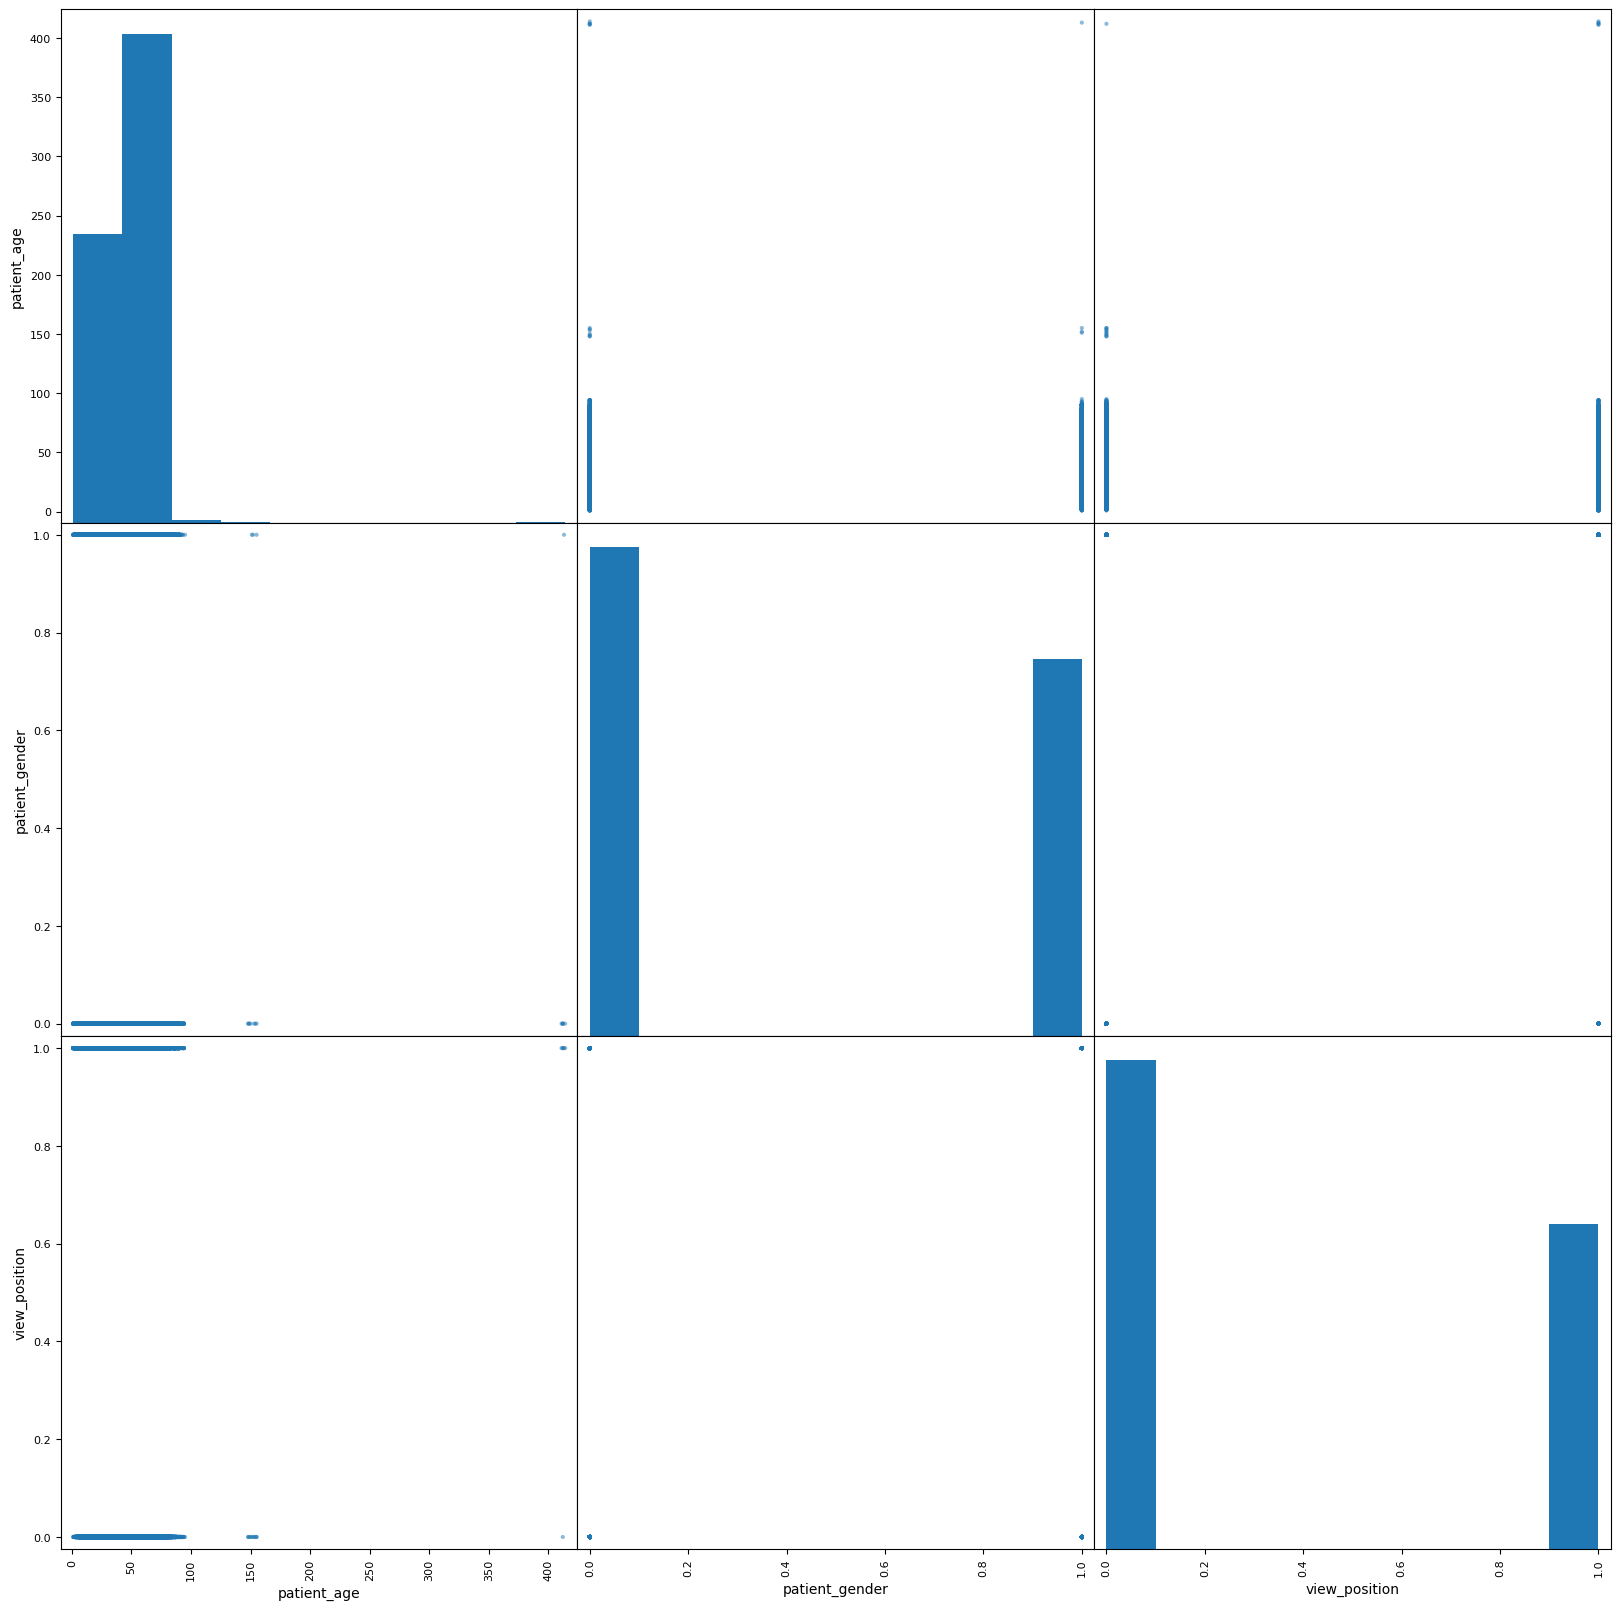

In [17]:

#Scatterplot matrix
if not numeric_features_patients.empty and not numeric_features_patients.isnull().all(axis=0).any():
    pd.plotting.scatter_matrix(numeric_features_patients, figsize=(20, 20))
    plt.show()
else:
    print("No valid numeric data available for scatter matrix.")    #No valid numeric data available for scatter matrix.


In [18]:
patients['patient_age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: patient_age, dtype: float64

In [19]:
# maximum patient age does not make sense, most likely bad data since values were obtained via text mining
# clipping the maximum age at 120 years
patients['patient_age'] = patients['patient_age'].clip(upper=120)
patients['patient_age'].describe()

count    112120.000000
mean         46.883009
std          16.619939
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         120.000000
Name: patient_age, dtype: float64

In [20]:
#Scale the data
scaler = MinMaxScaler()
patients[numeric_features_patients.columns] = scaler.fit_transform(patients[numeric_features_patients.columns])

In [21]:
patients.head()

,image_index,followup_,patient_id,patient_age,patient_gender,view_position,originalimagewidth,height,originalimagepixelspacingx,y,...,Consolidation,Pneumothorax,Edema,Hernia,Effusion,Fibrosis,Mass,Emphysema,Pneumonia,Pleural_Thickening
0,00000001_000.png,0,1,0.478992,0.0,0.0,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,0.478992,0.0,0.0,2894,2729,0.143,0.143,...,0,0,0,0,0,0,0,1,0,0
2,00000001_002.png,2,1,0.478992,0.0,0.0,2500,2048,0.168,0.168,...,0,0,0,0,1,0,0,0,0,0
3,00000002_000.png,0,2,0.672269,0.0,0.0,2500,2048,0.171,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,3,0.672269,1.0,0.0,2582,2991,0.143,0.143,...,0,0,0,1,0,0,0,0,0,0


In [22]:
file_names = []
for root, dirs, files in os.walk(path):
    file_names.extend([filename for filename in files if '.png' in filename])
    
print(len(file_names))  # the number of image files should match the number of rows in patients

112120


In [23]:
# Filter the DataFrame for existing images
patients_with_images = patients[patients['image_index'].isin(file_names)]

print(patients_with_images.describe())


           followup_     patient_id    patient_age  patient_gender  \
count  112120.000000  112120.000000  112120.000000   112120.000000   
mean        8.573751   14346.381743       0.385572        0.435070   
std        15.406320    8403.876972       0.139663        0.495768   
min         0.000000       1.000000       0.000000        0.000000   
25%         0.000000    7310.750000       0.285714        0.000000   
50%         3.000000   13993.000000       0.403361        0.000000   
75%        10.000000   20673.000000       0.487395        1.000000   
max       183.000000   30805.000000       1.000000        1.000000   

       view_position  originalimagewidth         height  \
count  112120.000000       112120.000000  112120.000000   
mean        0.399661         2646.078844    2486.438842   
std         0.489831          341.246429     401.268227   
min         0.000000         1143.000000     966.000000   
25%         0.000000         2500.000000    2048.000000   
50%         0.0

In [24]:
batch_size = 32

# Loads images from all subdirectories
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path,
    labels=None,
    image_size=(224, 224),  # all images are resized to this size. Should match model's expectations
    batch_size=None # batching is applied to the full dataset later
)

Found 112120 files belonging to 1 classes.


In [25]:
# Map image filenames to row data in patients. Reindex patients to match image order (this will throw an error if there are any image files without an associated row)
reindexed_patients = patients.set_index("image_index")
image_mapped_patients = reindexed_patients.loc[[path.split("\\")[-1] for path in image_dataset.file_paths]]
dataset_length = len(image_mapped_patients)


In [26]:

# Convert feature and label data to TensorFlow datasets
features_dataset = tf.data.Dataset.from_tensor_slices(image_mapped_patients[feature_columns].values)
labels_dataset = tf.data.Dataset.from_tensor_slices(image_mapped_patients[label_columns].values)

combined_dataset = tf.data.Dataset.zip(((image_dataset, features_dataset), labels_dataset))
image_and_labels_dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))

In [27]:
# randomize the order of the dataset so we are not splitting the sets based on which folder the images are in
combined_dataset = combined_dataset.shuffle(buffer_size=1000, seed=1)
image_and_labels_dataset = image_and_labels_dataset.shuffle(buffer_size=1000, seed=1)

# Split into train and test sets (may add validation in the future)
train_size = int(0.7 * dataset_length)
test_size = dataset_length - train_size
print(f'train_size: {train_size}')

combined_train_dataset = combined_dataset.take(train_size)
combined_test_dataset = combined_dataset.skip(train_size)

combined_train_dataset = combined_train_dataset.batch(batch_size)
combined_test_dataset = combined_test_dataset.batch(batch_size)

combined_train_dataset = combined_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
combined_test_dataset = combined_test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

image_and_labels_train_dataset = image_and_labels_dataset.take(train_size)
image_and_labels_test_dataset = image_and_labels_dataset.skip(train_size)

image_and_labels_train_dataset = image_and_labels_train_dataset.batch(batch_size)
image_and_labels_test_dataset = image_and_labels_test_dataset.batch(batch_size)

image_and_labels_train_dataset = image_and_labels_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
image_and_labels_test_dataset = image_and_labels_test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

train_size: 78484


### Methodology

A pretrained CNN was used for each attempt, taking as input a 224x224 image
The top (output) layer was removed from the CNN and followed by one or more Dense layers
The output was a final dense layer with one node for each label
The sigmoid activation function was used for output nodes since each label was represented as a binary classification independent of the other labels
We used the Adam optimizer and the binary cross entropy loss function
A weight was computed for each class, inversely proportional to the class’s frequency, so that examples with less common classes would have greater impact on the loss function

### Model Fitting and Validation

1. model 1 
    - decription 
2. model 2
    - decription 

In [28]:
def build_and_compile_ResNet50_CNN_only():
    
    # Load the ResNet50 model without the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    image_input = base_model.input

    # Freeze the layers of ResNet50 so that they are not trainable
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    
    x = Flatten()(x)
    
    # Final output layer for multi-label classification
    num_labels = len(label_columns)
    output = Dense(num_labels, activation="sigmoid")(x)  # Sigmoid for multi-label binary classification

    resnet_model = tf.keras.Model(inputs=[image_input], outputs=output)

    resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

    # Display model architecture
    print(resnet_model.summary())
    
    return resnet_model

# this call is just to display the model
build_and_compile_ResNet50_CNN_only()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [29]:
def build_and_compile_ResNet50():
    
    # Load the ResNet50 model without the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    image_input = base_model.input

    # Freeze the layers of ResNet50 so that they are not trainable
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)  # Flatten the output for merging with the numerical path

    # # Define the numerical input path
    patient_input = tf.keras.Input(shape=(len(feature_columns),), name="patient_input")
    y = Dense(8, activation="relu")(patient_input)

    # # Concatenate the outputs from the two paths
    combined = Concatenate()([x, y])

    # Fully connected layers for the merged path
    z = Dense(64, activation="relu")(combined)
    z = Dropout(0.3)(z)
    z = Dense(32, activation="relu")(z)

    # Final output layer for multi-label classification
    num_labels = len(label_columns)
    output = Dense(num_labels, activation="sigmoid")(z)  # Sigmoid for multi-label binary classification

    # Define the model with both inputs and the single output
    resnet_model = tf.keras.Model(inputs=[image_input, patient_input], outputs=output)

    # Compile the model
    resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

    # Display model architecture
    print(resnet_model.summary())
    
    return resnet_model

# this call is just to display the model
build_and_compile_ResNet50()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [30]:
def build_and_compile_EfficientNet_CNN_only():
    
    # Load the model without the top layer
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    image_input = base_model.input

    # Freeze the layers of so that they are not trainable
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    
    x = Flatten()(x)

    # Final output layer for multi-label classification
    num_labels = len(label_columns)
    output = Dense(num_labels, activation="sigmoid")(x)  # Sigmoid for multi-label binary classification

    # Define the model with both inputs and the single output
    model = tf.keras.Model(inputs=[image_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

    # Display model architecture
    print(model.summary())
    
    return model

# this call is just to display the model
build_and_compile_EfficientNet_CNN_only()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0][0]']    

In [31]:
# helper function to display the graph of training accuracy / loss over training epochs
def display_history_graphs(history):
        # Plot training & validation accuracy values
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        
        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        # plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        
        plt.tight_layout()
        plt.show()

In [32]:
def train_or_load_model(training_dataset, build_function, model_file_path):
    model = None
    if os.path.exists(model_file_path):
        print("Loading saved model.")
        
        model = tf.keras.models.load_model(model_file_path)
    else:
        print("No saved model found. Training new model.")
        model = build_function()
        history = model.fit(
            training_dataset,
            epochs=10,
            class_weight=class_weight_dict
        )
        # Save the trained weights
        print("Saving new model weights.")
        model.save(model_file_path)

        display_history_graphs(history)
    
    return model

In [33]:
def generate_or_retrieve_predictions(model, test_dataset, prediction_filepath):
    predictions = None

    if os.path.exists(prediction_filepath):
        print("Loading saved predictions.")
        with open(prediction_filepath, 'r') as predictions_file:
            stored_predictions = json.load(codecs.open(prediction_filepath, 'r', encoding='utf-8'))
            predictions = np.asarray(stored_predictions)
    else:
        print('No saved predictions found. Generating predictions on test dataset.')
        predictions = model.predict(test_dataset)
        
        print('Saving new predictions.')
        json.dump(predictions.tolist(), codecs.open(prediction_filepath, 'w', encoding='utf-8'))
        
    return predictions

In [34]:
# we don't need to do this multiple times assuming all test datasets are the same size
y_true = np.concatenate([y for x, y in combined_test_dataset], axis=0)

# display a number of metrics based on a model's predictions
def display_prediction_results(predictions, test_dataset):
    # Number of labels
    num_labels = y_true.shape[1]

    # Initialize figure for ROC curves
    plt.figure(figsize=(10, 8))

    # Compute ROC curve and AUC for each label
    for i in range(num_labels):
        fpr, tpr, _ = roc_curve(y_true[:, i], predictions[:, i])
        auc = roc_auc_score(y_true[:, i], predictions[:, i])
        plt.plot(fpr, tpr, label=f'Label {i} (AUC = {auc:.2f})')

    # Finalize plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Label Classification')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.show()

    threshold = 0.2
    binary_predictions = (predictions > threshold).astype(int)

    # Generate a classification report
    print(classification_report(y_true, binary_predictions))
    for i, confusion_matrix in enumerate(multilabel_confusion_matrix(y_true, binary_predictions)):
        print(label_columns[i])
        print(confusion_matrix)

### Model Evaluation 

* Examine your models (coefficients, parameters, errors, etc...)

* Compute and interpret your results in terms of accuracy, precision, recall, ROC etc. 

Loading saved model.
Loading saved predictions.


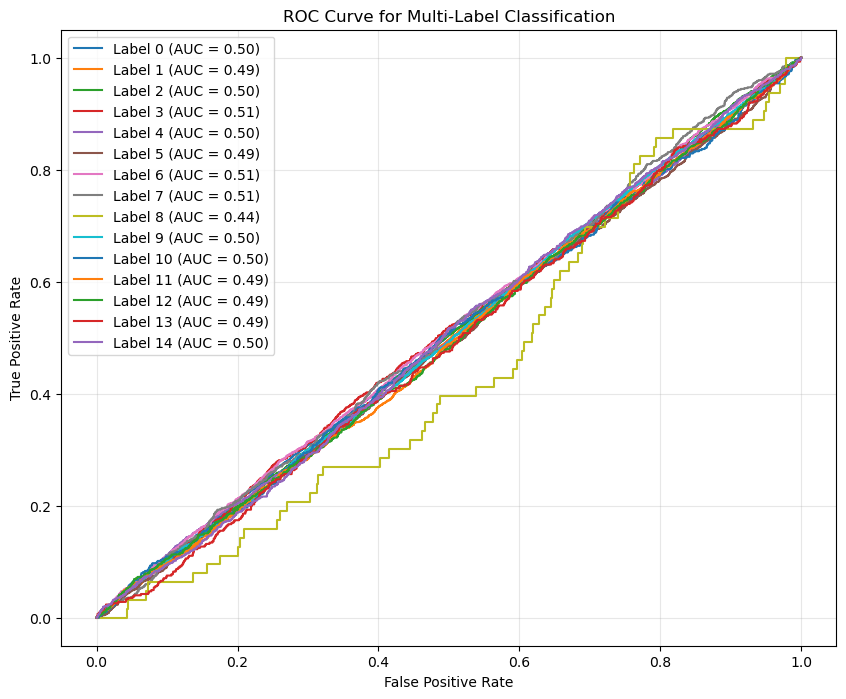

              precision    recall  f1-score   support

           0       0.55      0.27      0.36     18181
           1       0.17      0.16      0.16      5871
           2       0.10      0.16      0.13      3499
           3       0.02      0.10      0.04       825
           4       0.06      0.27      0.09      1874
           5       0.04      0.41      0.07      1380
           6       0.05      0.19      0.08      1585
           7       0.02      0.23      0.04       700
           8       0.00      0.00      0.00        63
           9       0.13      0.02      0.03      3900
          10       0.02      0.45      0.03       503
          11       0.06      0.06      0.06      1746
          12       0.02      0.29      0.04       796
          13       0.05      0.00      0.01       425
          14       0.03      0.13      0.04      1003

   micro avg       0.09      0.21      0.13     42351
   macro avg       0.09      0.18      0.08     42351
weighted avg       0.29   

c:\Users\andrew.dant\AppData\Local\anaconda3\envs\AI-570\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
CNN_resnet_model = train_or_load_model(image_and_labels_train_dataset, build_and_compile_ResNet50_CNN_only, "ResNet50_CNNonly.h5")
CNN_ResNet50_predictions = generate_or_retrieve_predictions(CNN_resnet_model, image_and_labels_test_dataset, 'ResNet50_CNNonly_predictions.json')
display_prediction_results(CNN_ResNet50_predictions, image_and_labels_test_dataset)

Loading saved model.
Loading saved predictions.


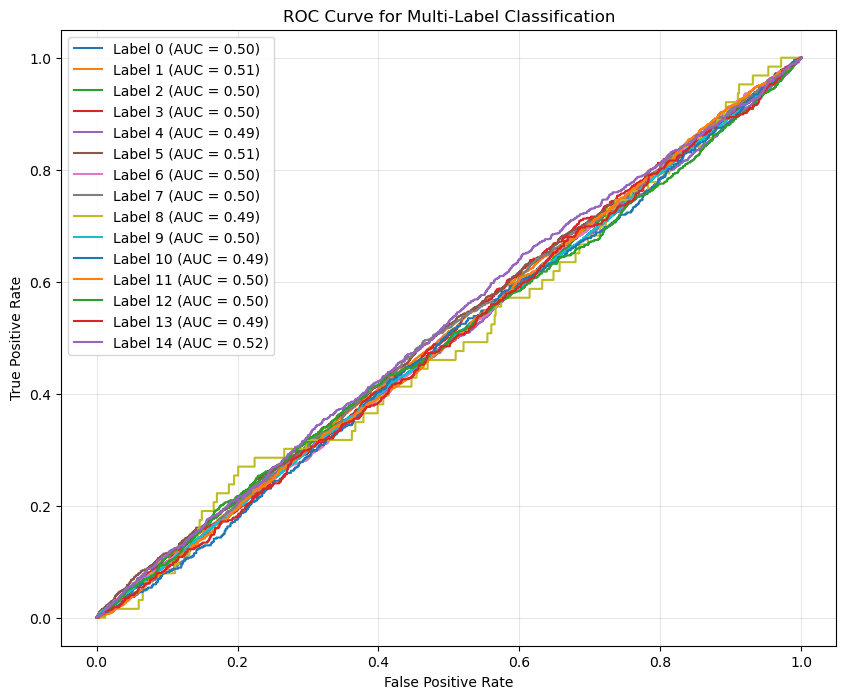

              precision    recall  f1-score   support

           0       0.52      0.02      0.03     18181
           1       0.19      0.05      0.08      5871
           2       0.11      0.17      0.13      3499
           3       0.02      0.02      0.02       825
           4       0.00      0.00      0.00      1874
           5       0.10      0.00      0.00      1380
           6       0.00      0.00      0.00      1585
           7       0.06      0.00      0.01       700
           8       0.00      0.00      0.00        63
           9       0.11      0.23      0.15      3900
          10       0.02      0.43      0.03       503
          11       0.05      0.42      0.09      1746
          12       0.00      0.00      0.00       796
          13       0.00      0.00      0.00       425
          14       0.04      0.00      0.00      1003

   micro avg       0.07      0.07      0.07     42351
   macro avg       0.08      0.09      0.04     42351
weighted avg       0.28   

c:\Users\andrew.dant\AppData\Local\anaconda3\envs\AI-570\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andrew.dant\AppData\Local\anaconda3\envs\AI-570\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
combined_resnet_model = train_or_load_model(combined_train_dataset, build_and_compile_ResNet50, "ResNet50_base.h5")
combined_ResNet50_predictions = generate_or_retrieve_predictions(combined_resnet_model, combined_test_dataset, 'ResNet50_base_predictions.json')
display_prediction_results(combined_ResNet50_predictions, combined_test_dataset)

Loading saved model.
Loading saved predictions.


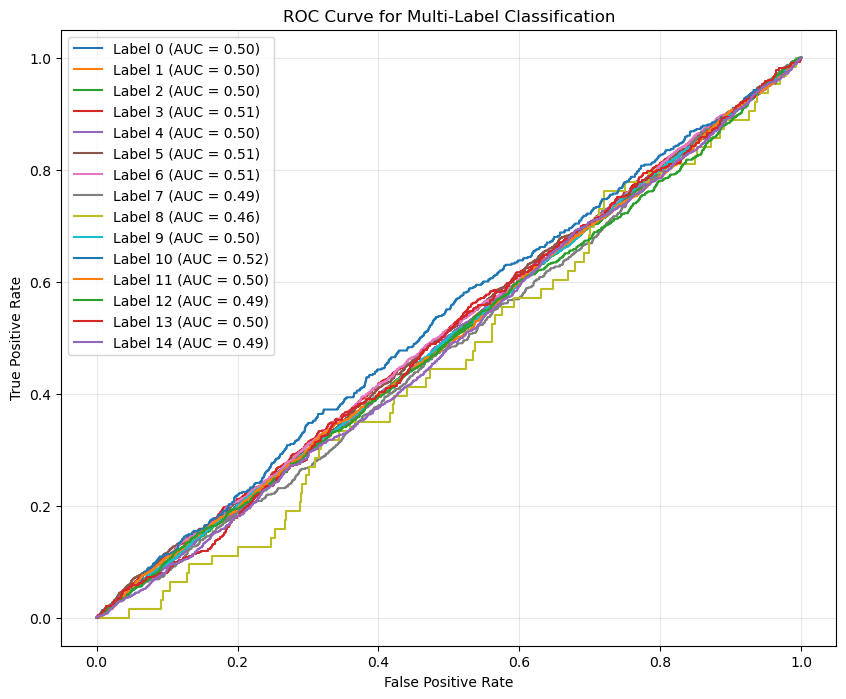

              precision    recall  f1-score   support

           0       0.53      0.09      0.15     18181
           1       0.17      0.31      0.22      5871
           2       0.10      0.05      0.07      3499
           3       0.03      0.13      0.05       825
           4       0.07      0.00      0.01      1874
           5       0.04      0.17      0.07      1380
           6       0.05      0.33      0.08      1585
           7       0.02      0.05      0.03       700
           8       0.00      0.10      0.00        63
           9       0.11      0.04      0.05      3900
          10       0.02      0.09      0.03       503
          11       0.04      0.02      0.03      1746
          12       0.02      0.18      0.04       796
          13       0.01      0.20      0.02       425
          14       0.03      0.02      0.02      1003

   micro avg       0.08      0.12      0.10     42351
   macro avg       0.08      0.12      0.06     42351
weighted avg       0.28   

c:\Users\andrew.dant\AppData\Local\anaconda3\envs\AI-570\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
CNN_EfficientNet_model = train_or_load_model(image_and_labels_train_dataset, build_and_compile_EfficientNet_CNN_only, "EfficientNet_CNN.h5")
CNN_EfficientNet_predictions = generate_or_retrieve_predictions(CNN_EfficientNet_model, image_and_labels_test_dataset, 'EfficientNet_CNN_predictions.json')
display_prediction_results(CNN_EfficientNet_predictions, image_and_labels_test_dataset)

### Issues / Improvements
1. Multi Branch Neural Networks (MBNNs) are an alternative model architecture that may provide superior results for multi label classification
2. Typical oversampling techniques such as SMOTE are not intended for multi-label classification. Multi label oversampling algorithms are more complex, but would be a valuable direction for future efforts towards addressing this problem
3. Properly using the sparse and imbalanced dataset would have required additional preprocessing and experimentation

###  References

* Asif Iqbal Khan, Junaid Latief Shah, Mohammad Mudasir Bhat. CoroNet: A deep neural network for detection and diagnosis of COVID-19 from chest x-ray images. ScienceDirect 2020. https://www.sciencedirect.com/science/article/pii/S0169260720314140.
* Mobark, N.; Hamad, S.; Rida, S.Z. CoroNet: Deep Neural Network-Based End-to-End Training for Breast Cancer Diagnosis. Appl. Sci. 2022, 12, 7080. https://doi.org/ 10.3390/app12147080
* NIH Chest X-rays 2023. https://www.kaggle.com/datasets/nih-chest-xrays/data/data 
* Solemane Coulibaly , Bernard Kamsu-Foguem, Dantouma Kamissoko, Daouda Traore. Deep Convolutional Neural Network sharing for the multi-label images classification. ScienceDirect 2022.
* Wang, X., Peng, Y., Lu, L., Lu, Z., Bagheri, M., & Summers, R. M. (2017). Chestx-Ray8: Hospital-scale chest X-ray database and benchmarks on weakly-supervised classification and localization of common thorax diseases. 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). https://doi.org/10.1109/cvpr.2017.369 
* Zeyu Teng, Peng Cao, Min Huang, Zheming Gao, Xingwei Wan. Multi-label borderline oversampling technique. ScienceDirect 2024.


# End of Project